In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

### Ingestamos y transformarciones previas

In [4]:
train = pd.read_parquet('train.parquet', engine= 'pyarrow')
test = pd.read_parquet('test.parquet', engine = 'pyarrow')

Creación de una nueva columna

In [5]:
def range_price(dataframe):
    '''Se colocará las siguientes palabras segun los rango de precio:
        1 : Para precios entre 0 y 999 dólares
        0 : Para precios mayores a 1000 dólares'''
    lista = []
    for i in range(0,len(dataframe)):
        x = dataframe.iloc[i,4]
        if x >= 0 and x <= 999:
            category = 1
            lista.append(category)
        else:
            category = 0
            lista.append(category)
    nueva = pd.Series(lista, name = 'category_price')
    concat = pd.concat([dataframe,nueva],axis = 1)
    return concat


In [6]:
train = range_price(train)

### Análizis exploratorio de datos (EDA) 

Vemos el tamaño del dataset

In [7]:
train.shape

(346479, 23)

Mostramos los primeros 5 valores del dataframe

In [8]:
train.head(5)

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state,category_price
0,7048013474,https://boise.craigslist.org/apa/d/very-nice-b...,boise,https://boise.craigslist.org,1350,house,1200,2,2.0,1,...,0,0,w/d in unit,detached garage,https://images.craigslist.org/00B0B_cPiJMEheZe...,Super cute row house in the Boise bench area. ...,43.5851,-116.2250,id,0
1,7043931179,https://cosprings.craigslist.org/apa/d/colorad...,colorado springs,https://cosprings.craigslist.org,1115,apartment,694,1,1.0,1,...,0,0,w/d in unit,carport,https://images.craigslist.org/00R0R_5XAoSKvfrz...,Windtree Apartment Homes currently has a spaci...,38.9137,-104.7800,co,0
2,7048254516,https://norfolk.craigslist.org/apa/d/virginia-...,norfolk / hampton roads,https://norfolk.craigslist.org,1129,apartment,900,2,2.0,0,...,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00f0f_3ZbTFrsHpZ...,Call Today! show contact info Indian Lakes ...,36.7922,-76.1643,va,0
3,7041032577,https://phoenix.craigslist.org/nph/apa/d/phoen...,phoenix,https://phoenix.craigslist.org,1580,house,1469,3,2.0,1,...,0,0,w/d in unit,None,https://images.craigslist.org/00f0f_aXV5Dkd5qk...,Cody Anderson Two Brothers Realty License #: S...,33.5623,-112.0560,az,0
4,7048588701,https://nashville.craigslist.org/apa/d/antioch...,nashville,https://nashville.craigslist.org,995,apartment,700,1,1.0,1,...,0,0,w/d in unit,carport,https://images.craigslist.org/00606_gYOGKClOHv...,To schedule a tour We now book our tour appoin...,36.0595,-86.6592,tn,1


Observamos el tipo de dato de cada columna

In [9]:
train.dtypes

id                           int64
url                         object
region                      object
region_url                  object
price                        int64
type                        object
sqfeet                       int64
beds                         int64
baths                      float64
cats_allowed                 int64
dogs_allowed                 int64
smoking_allowed              int64
wheelchair_access            int64
electric_vehicle_charge      int64
comes_furnished              int64
laundry_options             object
parking_options             object
image_url                   object
description                 object
lat                        float64
long                       float64
state                       object
category_price               int64
dtype: object

Graficamos cuantos nulos hay por cada columna

<AxesSubplot: title={'center': 'Columnas de nulos'}, ylabel='Proporcion nulos'>

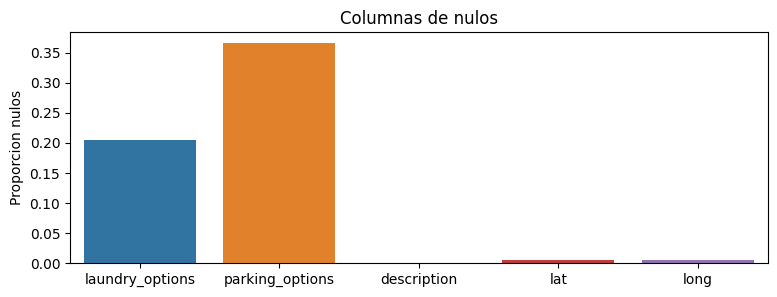

In [10]:
nulos_porcentaje = train.isnull().sum() / len(train)
nulos_porcentaje = nulos_porcentaje[nulos_porcentaje > 0]
fig = plt.figure(figsize=(9,3),dpi=100)
plt.title('Columnas de nulos')
plt.ylabel('Proporcion nulos')
sns.barplot(x=nulos_porcentaje.index,y=nulos_porcentaje.values)

Visualizamos las columnas con los faltos faltantes

In [11]:
train.isnull().sum()

id                              0
url                             0
region                          0
region_url                      0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             71171
parking_options            126682
image_url                       0
description                     2
lat                          1722
long                         1722
state                           0
category_price                  0
dtype: int64

Revisamos si hay registros duplicados

In [12]:
#Revisión si hay filas duplicadas
print(train[train.duplicated()])
#Revisón si hay duplicados en la columna 'id'
print(train[train.duplicated('id')])

Empty DataFrame
Columns: [id, url, region, region_url, price, type, sqfeet, beds, baths, cats_allowed, dogs_allowed, smoking_allowed, wheelchair_access, electric_vehicle_charge, comes_furnished, laundry_options, parking_options, image_url, description, lat, long, state, category_price]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [id, url, region, region_url, price, type, sqfeet, beds, baths, cats_allowed, dogs_allowed, smoking_allowed, wheelchair_access, electric_vehicle_charge, comes_furnished, laundry_options, parking_options, image_url, description, lat, long, state, category_price]
Index: []

[0 rows x 23 columns]


Eliminar las filas que tienen nulos de las columnas de 'lat' y 'long'

In [13]:
train.dropna(subset = ['lat', 'long'], inplace = True)

Eliminamos los inmubles que se duplican según coordenadas geográficas (latitud y longitud)

In [14]:
train = train[train[['lat','long']].duplicated() == False]

Se reemplazan los NaN por 'not specified'

In [15]:
#Reemplazamos los NaN por un 'not specified' ya que especificamente de esas columnas se pueden "obviar"
train.fillna('not specified', inplace = True)

Eliminamos los duplicados de las filas que tengan igual las columnas de 'type', 'price', 'sqfeet', 'description' y 'region'

In [16]:
#Filtro por esas caracteristicas ya que si se tiene el mismo precio, tipo, metros cuadrados, description y region 
# es muy probable que ese inmuble sea duplicado
train = train[train[['type','price','sqfeet','region']].duplicated() == False]

### Confirmamos que todos los inmubles se encuentren en USA

Visualización rapida de la ubicación de los inmuebles

<AxesSubplot: xlabel='long', ylabel='lat'>

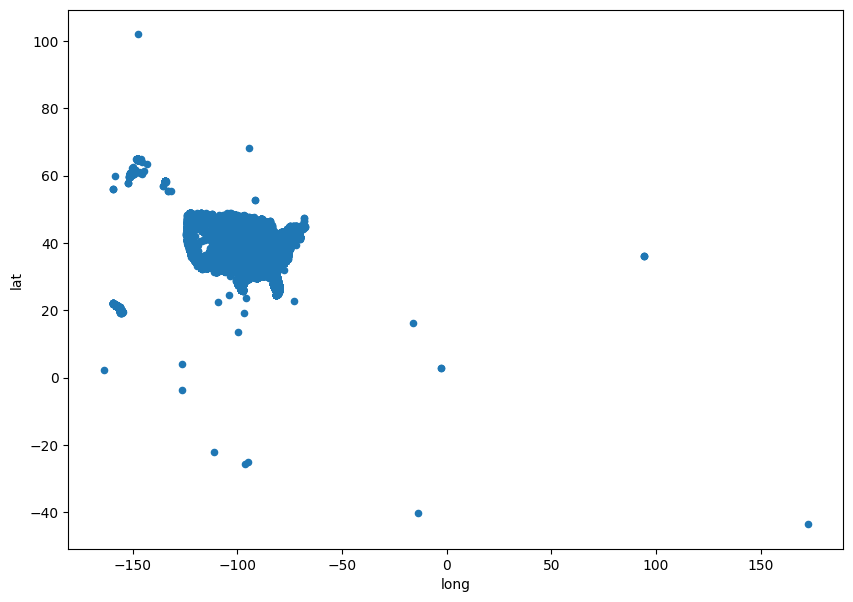

In [17]:
train.plot(kind = 'scatter',x = 'long',y = 'lat',figsize = (10,7))

Eliminamos los datos que no correspondan a USA

In [18]:
#Se crea una función para depurar los inmubles fuera los estados unidos
def delete_outside_USA(dataframe):
    '''Esta función recibe un dataframe para depurar los datos que se salen de las coordenadas geofraficas
    de los estados unidos (Renombrar las columnas como 'lat' y 'long' en la columnas de latitud y longitud respectivamente )'''
    #La latitud más lejana del territorio americano (sin AlasKa) hacia Norte
    USA =  dataframe[(dataframe['lat'] < 48.965542611271246) == True]
    #La latitud más lejana del territorio americano (sin AlasKa) hacia Sur
    USA = USA[(USA['lat'] > 25.18859809405952) == True]
    #La longitud más lejana del territorio americano (sin AlasKa) hacia Oeste
    USA = USA[(USA['long'] < -66.95147200983982 ) == True]
    #La longitud más lejana del territorio americano (sin AlasKa) hacia Este
    USA = USA[(USA['long'] > -124.65473005931817 ) == True]

    #La latitud más lejana de Alaska hacia Norte
    AK = dataframe[(dataframe['lat'] < 71.31394314919739) == True]
    #La latitud más lejana de Alaska hacia Sur
    AK = AK[(AK['lat'] > 54.80972378535213) == True]
    #La longitud más lejana de Alaska hacia Oeste
    AK = AK[(AK['long'] > -168.09468095117154) == True]
    #La longitud más lejana de Alaska hacia Este
    AK = AK[(AK['long'] < -130.79175314074158) == True]
    
    train_data = pd.concat([USA,AK])

    #Las latitudes y longitudes fueron sacados de datos de google Maps
    return train_data

In [19]:
train = delete_outside_USA(train)

Visualizamos los inmubles con un mapa de calor

In [20]:
mapa = folium.Map(location=[37.0902405, -95.7128906], zoom_start= 3)
inmubles = train[['lat','long']].to_numpy()
HeatMap(data = inmubles, radius=12).add_to(mapa)
mapa

Matrix de correlación

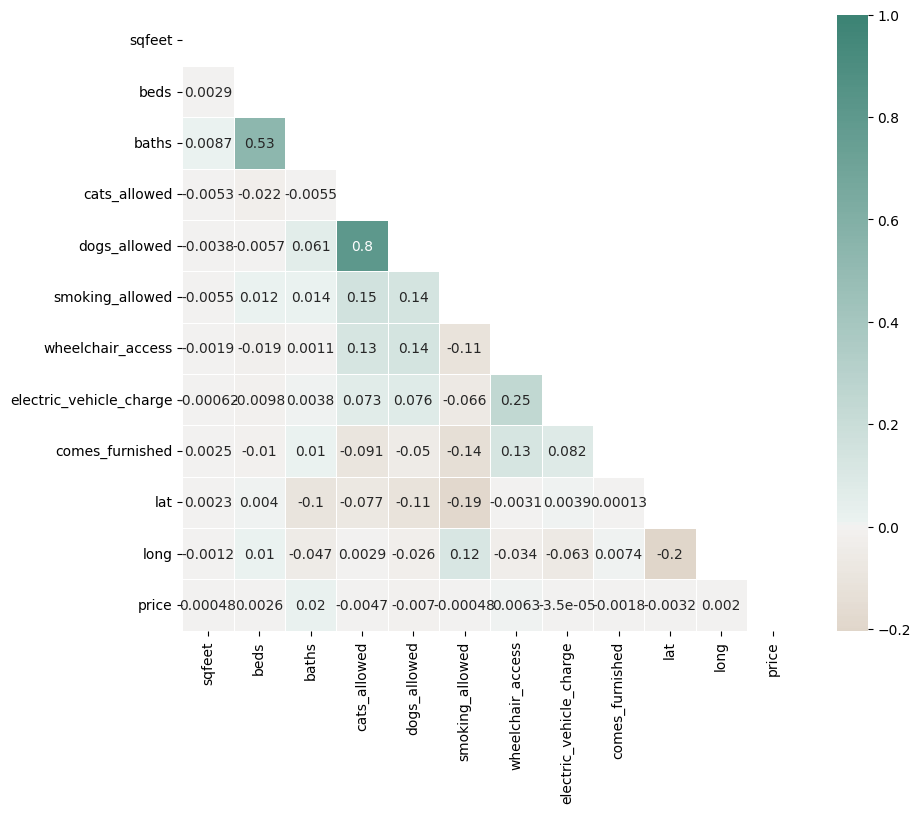

In [21]:
#Creamos la matrix de correlación para ver las columnas más relacionadas con los precios
x = train[['sqfeet','beds','baths','cats_allowed','dogs_allowed','smoking_allowed','wheelchair_access',
'electric_vehicle_charge','comes_furnished','lat','long','price']]
f, ax = plt.subplots(figsize=(10, 8))
filtro = x.corr()
mask = np.triu(np.ones_like(filtro, dtype=bool))
cmap = sns.diverging_palette(50, 170, as_cmap=True)
sns.heatmap(filtro, mask = mask, cmap = cmap, vmax = 1, center = 0, annot = True,square = True, linewidths = 0.5)
plt.show()

### Creación del modelo

Creo el modelo de árbol de clasificación

In [22]:
#Guardamos el modelo
tree = DecisionTreeClassifier()

In [23]:
#Se selecionan las columnas para el entrenamiento
X=train[['sqfeet','beds','baths','cats_allowed','dogs_allowed','smoking_allowed','wheelchair_access','electric_vehicle_charge',
'comes_furnished','lat','long']]
#Se seleciona la variable objetivo
y=train['category_price']

#Se divide el dataframe en 2: Entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
#Entrenamos el modelo
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
#Se hace la predicción del modelo
y_pred = tree.predict(X_test)

Verificamos el accurancy y el recall

In [26]:
#Se calcula la accurancy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
#Se calcula el recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall}')

Accuracy: 0.7954292969369942
Recall: 0.723298969072165


### Predicción

Preparación del dataframe 'test'

In [27]:
#Visualizamos los 5 primeros registros
test.head(5)

,id,url,region,region_url,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7037609789,https://annarbor.craigslist.org/apa/d/wixom-ho...,ann arbor,https://annarbor.craigslist.org,manufactured,1344,3,2.0,0,0,...,0,0,0,w/d in unit,off-street parking,https://images.craigslist.org/00M0M_iNczP1nzIL...,"OPEN HOUSE TODAY! APPLY THIS WEEK, PUT A HOLDI...",42.5333,-83.5763,mi
1,7032406876,https://vermont.craigslist.org/apa/d/randolph-...,vermont,https://vermont.craigslist.org,apartment,1050,2,1.0,0,0,...,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00L0L_ecirmYBIzL...,"Think of it, you'll be first to get your mail....",43.9393,-72.5538,vt
2,7037022682,https://annarbor.craigslist.org/apa/d/ann-arbo...,ann arbor,https://annarbor.craigslist.org,apartment,1150,2,2.0,1,1,...,1,0,0,w/d in unit,carport,https://images.craigslist.org/00e0e_dPln2xjo9g...,One of Ann Arbor's most luxurious apartment co...,42.2492,-83.7712,mi
3,7048681802,https://fortcollins.craigslist.org/apa/d/fort-...,fort collins / north CO,https://fortcollins.craigslist.org,apartment,1280,2,2.5,1,1,...,0,0,0,w/d in unit,attached garage,https://images.craigslist.org/00L0L_jlektT5cSd...,"Specials! Move in before January 16th, 2020 an...",40.5501,-105.0350,co
4,7043597870,https://charlottesville.craigslist.org/apa/d/c...,charlottesville,https://charlottesville.craigslist.org,apartment,783,2,1.0,1,1,...,0,0,0,laundry on site,None,https://images.craigslist.org/00D0D_cXa4KbZ6ox...,Barracks West Apartments & Townhomes in Charlo...,38.0936,-78.5611,va


In [28]:
#Visualizamos los nulos
test.isnull().sum()

id                             0
url                            0
region                         0
region_url                     0
type                           0
sqfeet                         0
beds                           0
baths                          0
cats_allowed                   0
dogs_allowed                   0
smoking_allowed                0
wheelchair_access              0
electric_vehicle_charge        0
comes_furnished                0
laundry_options             7855
parking_options            14005
image_url                      0
description                    0
lat                          196
long                         196
state                          0
dtype: int64

In [29]:
#Por fines practicos llenamos los NaN de 'lat' y 'long' por la media de ambos y los NaN de 'laundry_options','parking_options' 
# por 'not specified'
test['lat'].fillna(test['lat'].mean(),inplace = True)
test['long'].fillna(test['long'].mean(),inplace = True)
test['laundry_options'].fillna('not specified', inplace=True)
test['parking_options'].fillna('not specified', inplace=True)


In [30]:
test.isnull().sum()

id                         0
url                        0
region                     0
region_url                 0
type                       0
sqfeet                     0
beds                       0
baths                      0
cats_allowed               0
dogs_allowed               0
smoking_allowed            0
wheelchair_access          0
electric_vehicle_charge    0
comes_furnished            0
laundry_options            0
parking_options            0
image_url                  0
description                0
lat                        0
long                       0
state                      0
dtype: int64

Hacemos la predicción con el dataframe de test

In [31]:
X_test = test[['sqfeet','beds','baths','cats_allowed','dogs_allowed','smoking_allowed','wheelchair_access','electric_vehicle_charge',
'comes_furnished','lat','long']]

pred = pd.DataFrame(tree.predict(X_test), columns=['prediction'])

Exportamos el dataframe como csv

In [33]:
pred.to_csv('fransc02.csv', index=False)